In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from scipy import signal

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

data_dir = pathlib.Path('data')

In [12]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

720


In [19]:
batch_size = 32
img_height = 177
img_width = 683

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 720 files belonging to 2 classes.
Using 576 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 720 files belonging to 2 classes.
Using 144 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['adhd', 'normal']


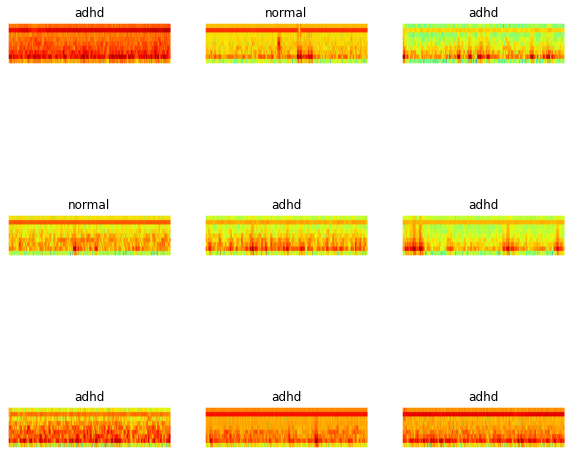

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 177, 683, 3)
(32,)


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = layers.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 177, 683, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 177, 683, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 341, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 341, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 170, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 170, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 85, 64)        0

In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
18/18 [==============================] - 31s 2s/step - loss: 1.3584 - accuracy: 0.5694 - val_loss: 0.6649 - val_accuracy: 0.6944
Epoch 2/10
18/18 [==============================] - 28s 2s/step - loss: 0.6260 - accuracy: 0.6823 - val_loss: 0.6159 - val_accuracy: 0.7222
Epoch 3/10
18/18 [==============================] - 28s 2s/step - loss: 0.5724 - accuracy: 0.7188 - val_loss: 0.5970 - val_accuracy: 0.7153
Epoch 4/10
18/18 [==============================] - 27s 2s/step - loss: 0.5405 - accuracy: 0.7309 - val_loss: 0.6197 - val_accuracy: 0.7153
Epoch 5/10
18/18 [==============================] - 27s 2s/step - loss: 0.5598 - accuracy: 0.7014 - val_loss: 0.5819 - val_accuracy: 0.7014
Epoch 6/10
18/18 [==============================] - 28s 2s/step - loss: 0.5198 - accuracy: 0.7500 - val_loss: 0.6559 - val_accuracy: 0.6667
Epoch 7/10
18/18 [==============================] - 30s 2s/step - loss: 0.5003 - accuracy: 0.7569 - val_loss: 0.6263 - val_accuracy: 0.6597
Epoch 8/10
18/18 [==

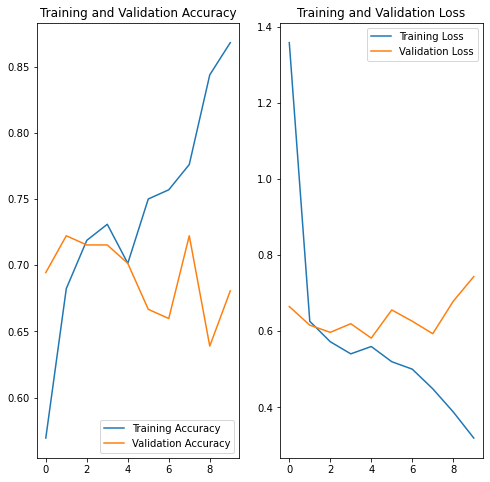

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

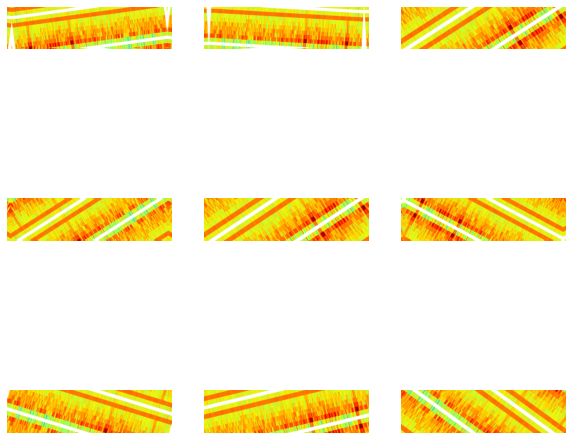

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [40]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 177, 683, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 177, 683, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 177, 683, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 88, 341, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 88, 341, 32)       4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 44, 170, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 170, 64)      

In [43]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
18/18 [==============================] - 33s 2s/step - loss: 1.4368 - accuracy: 0.5556 - val_loss: 0.6799 - val_accuracy: 0.5556
Epoch 2/15
18/18 [==============================] - 32s 2s/step - loss: 0.6474 - accuracy: 0.6302 - val_loss: 0.6247 - val_accuracy: 0.6806
Epoch 3/15
18/18 [==============================] - 33s 2s/step - loss: 0.6050 - accuracy: 0.7066 - val_loss: 0.6544 - val_accuracy: 0.7083
Epoch 4/15
18/18 [==============================] - 33s 2s/step - loss: 0.6002 - accuracy: 0.7031 - val_loss: 0.6532 - val_accuracy: 0.7014
Epoch 5/15
18/18 [==============================] - 32s 2s/step - loss: 0.5845 - accuracy: 0.7031 - val_loss: 0.6416 - val_accuracy: 0.7014
Epoch 6/15
18/18 [==============================] - 32s 2s/step - loss: 0.5776 - accuracy: 0.7188 - val_loss: 0.6314 - val_accuracy: 0.6597
Epoch 7/15
18/18 [==============================] - 36s 2s/step - loss: 0.5911 - accuracy: 0.6858 - val_loss: 0.6158 - val_accuracy: 0.6875
Epoch 8/15
18/18 [==

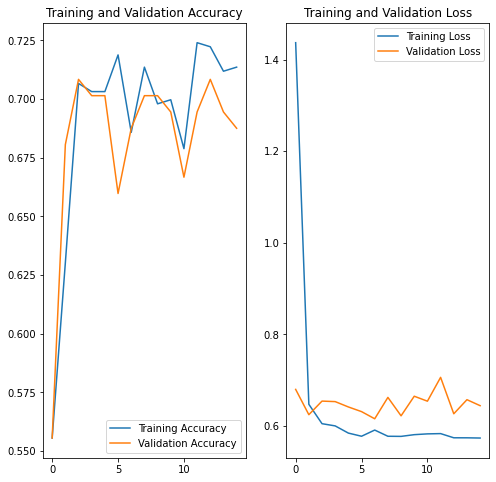

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()